In [242]:
import os
import sys
from copy import deepcopy

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam

sys.path.append(os.path.abspath(".."))

from rlib.common.logger import Logger
from rlib.common.evaluation import get_trajectory, validation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
env = gym.make("Pendulum-v1")

### DDPG

In [230]:
class OrnsteinUhlenbeckNoise():
    def __init__(self, shape, alpha: float = 0.15, sigma: float = 0.2):
        self.shape = shape
        self.alpha = alpha
        self.sigma = sigma

        self.loc = torch.zeros(shape, dtype=torch.float32)
        self.scale = sigma * torch.ones(shape, dtype=torch.float32)
        self.dist = Normal(self.loc, self.scale)

        self.reset()

    def sample(self):
        self.state = self.alpha * self.state + self.dist.sample()        
        return self.state

    def reset(self):
        self.state = torch.zeros(self.shape)

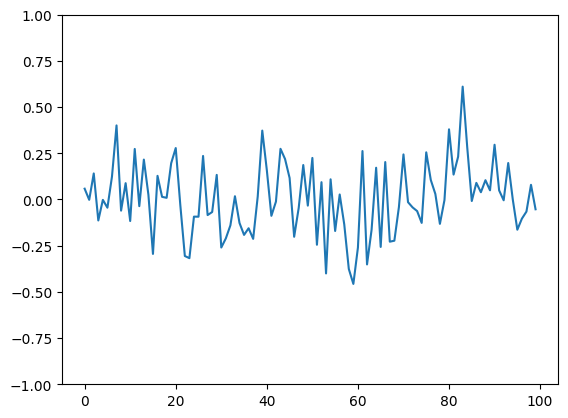

In [231]:
t = np.arange(100)
noise = np.zeros_like(t, dtype=np.float32)
ou_noise = OrnsteinUhlenbeckNoise((1,))

for i in range(t.size):
    noise[i] = ou_noise.sample().numpy()[0]

plt.ylim((-1, 1))
plt.plot(t, noise)

In [232]:
class DeterministicMlpPolicy(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size=128, noise=OrnsteinUhlenbeckNoise):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.hidden_size = hidden_size

        self.shape = (1, self.action_dim)
        self.noise = noise(self.shape)

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): (B, obs_dim)

        Returns:
            output: (torch.Tensor): (B, action_dim)
        """
        output = torch.tanh(self.net(input))
        return output

    def get_action(self, input, deterministic=False):
        """
        Args:
            input (torch.Tensor): (B, obs_dim)

        Returns:
            action: (torch.Tensor): (B, action_dim)
            log_prob_action: (torch.Tensor): (B, 1)
        """
        action = self.forward(input)

        if not deterministic:
            epsilon = self.noise.sample()
            action += epsilon

        return action

    def predict(self, observation, action=None, deterministic=False):
        """
        Called for env observation

        Args:
            observation (np.ndarray): (obs_dim,)

        Returns:
            action: (np.ndarray): (action_dim,)
            log_prob_action: (torch.Tensor): (1, 1)
        """

        expected_shape = (self.obs_dim,)
        if observation.shape != (self.obs_dim,):
            raise ValueError(
                f"Expected shape {expected_shape}, but got {observation.shape}"
            )

        input = torch.FloatTensor(observation.reshape(1, self.obs_dim))

        action = self.get_action(input, deterministic)
        action = action.detach().numpy()
        action = action.reshape((self.action_dim,))

        return action, {}

In [233]:
class MlpQCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, observations, actions):
        """
        Args:
            observations (torch.Tensor): (B, obs_dim)
            actions (torch.Tensor): (B, action_dim)

        Returns:
            q_values: (torch.Tensor): (B, 1)
        """
        input = torch.cat((observations, actions), dim=1)
        return self.net(input)

In [234]:
class ReplayBuffer:
    def __init__(
        self, 
        obs_dim,
        action_dim,
        max_size: int = 10000,
    ):
        self.max_size = max_size

        self.size = 0
        self.pointer = 0
        self.curr_obs = None

        self.observations = np.zeros((max_size, obs_dim))
        self.next_observations = np.zeros((max_size, obs_dim))
        self.actions = np.zeros((max_size, action_dim))
        self.rewards = np.zeros((max_size,))
        self.terminated = np.zeros((max_size,))
        self.truncated = np.zeros((max_size,))

    def add_transition(self, obs, next_obs, action, reward, terminated, truncated):
        self.observations[self.pointer] = obs
        self.next_observations[self.pointer] = next_obs
        self.actions[self.pointer] = action
        self.rewards[self.pointer] = reward
        self.terminated[self.pointer] = terminated
        self.truncated[self.pointer] = truncated

        self.pointer = (self.pointer + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def collect_transition(self, env, policy):

        if self.curr_obs is None:
            self.curr_obs, _ = env.reset()

        action, _ = policy.predict(self.curr_obs)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        self.add_transition(self.curr_obs, next_obs, action, reward, terminated, truncated)

        if terminated or truncated:
            next_obs, _ = env.reset()

        self.curr_obs = next_obs
        
    def get_batch(self, batch_size):
        assert self.size >= batch_size, "Batch size greater than buffer size"

        indices = np.random.choice(range(self.size), batch_size, replace=False)

        batch = {
            "observations": torch.tensor(self.observations[indices], dtype=torch.float32),
            "next_observations": torch.tensor(self.next_observations[indices], dtype=torch.float32),
            "actions": torch.tensor(self.actions[indices], dtype=torch.float32),
            "rewards": torch.tensor(self.rewards[indices], dtype=torch.float32),
            "terminated": torch.tensor(self.terminated[indices], dtype=torch.bool),
            "truncated": torch.tensor(self.truncated[indices], dtype=torch.bool),
        }

        return batch

    def get_last_trajectory(self):
        pass # smth for logging

In [235]:
def ddpg_loss(data, actor, critic, actor_target, critic_target, gamma=0.99):
    loss = {}

    observations = data["observations"]

    actor_outputs = actor(observations)
    loss["actor"] = -critic(observations, actor_outputs).mean()

    actions = data["actions"]
    next_observations = data["next_observations"]
    rewards = data["rewards"].reshape(actor_outputs.shape)
    terminated = data["terminated"].reshape(actor_outputs.shape)

    with torch.no_grad():
        actions_target = actor_target(next_observations)
        targets = rewards + gamma * (~terminated) * critic_target(next_observations, actions_target)

    q_values = critic(observations, actions)
    loss["critic"] = ((q_values - targets) ** 2).mean()

    return loss

In [236]:
def smooth_update(model, target_model, tau: float = 0.99):
    for param, target_param in zip(model.parameters(), target_model.parameters()):
        new_terget_param = tau * target_param + (1 - tau) * param
        target_param.data.copy_(new_terget_param)

    return target_model

In [237]:
def ddpg(
    env,
    actor: DeterministicMlpPolicy,
    critic: MlpQCritic,
    actor_optimizer: Adam,
    critic_optimizer: Adam,
    training_starts: int = 1000,
    total_timesteps: int = 50_000,
    batch_size: int = 256,
    verbose: bool = True,
):
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    buffer = ReplayBuffer(obs_dim, action_dim)

    logger = Logger()

    actor_target = deepcopy(actor)
    critic_target = deepcopy(critic)

    steps_n = 0
    while steps_n < total_timesteps:
        buffer.collect_transition(env, actor)
        steps_n += 1

        if buffer.size < training_starts:
            continue

        batch = buffer.get_batch(batch_size)

        loss = ddpg_loss(batch, actor, critic, actor_target, critic_target)

        loss["actor"].backward()
        actor_optimizer.step()
        actor_optimizer.zero_grad()

        loss["critic"].backward()
        critic_optimizer.step()
        critic_optimizer.zero_grad()

        actor_target = smooth_update(actor, actor_target)
        critic_target = smooth_update(critic, critic_target)

        if verbose and steps_n % 10_000 == 0:
            trajectory = get_trajectory(env, actor)
            print(f"rewards: {sum(trajectory['rewards'])}")

        # logger.log(steps_n, batch)  # сюда не batch


In [238]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


In [239]:
actor = DeterministicMlpPolicy(obs_dim, action_dim)
critic = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_optimizer = Adam(critic.parameters(), lr=5e-4)

In [240]:
ddpg(env, actor, critic, actor_optimizer, critic_optimizer, total_timesteps=100_000)

rewards: -1068.56542533103
rewards: -1074.088344883167
rewards: -1351.8113017028047
rewards: -1010.6666505916216
rewards: -1232.5613793759574
rewards: -240.5518051456359
rewards: -123.35331231821063
rewards: -4.547379051501104
rewards: -494.13190761271306
rewards: -244.11086439803933


In [247]:
validation(env, actor)

np.float64(-307.0077192408973)

In [212]:
rb = ReplayBuffer(obs_dim, action_dim)

In [213]:
for _ in range(20):
    rb.collect_transition(env, actor)

In [220]:
actor_target = deepcopy(actor)
critic_target = deepcopy(critic)
gamma = 0.99

In [221]:
data = rb.get_batch(10)

In [227]:
loss = {}

observations = data["observations"]

actor_outputs = actor(observations)
loss["actor"] = -critic(observations, actor_outputs).mean()

actions = data["actions"]
next_observations = data["next_observations"]
rewards = data["rewards"].reshape(actor_outputs.shape)
terminated = data["terminated"].reshape(actor_outputs.shape)

with torch.no_grad():
    actions_target = actor_target(next_observations)
    targets = rewards + gamma * (~terminated) * critic_target(next_observations, actions_target)

q_values = critic(observations, actions)
loss["critic"] = ((q_values - targets) ** 2).mean()

print(actor_outputs.shape,  targets.shape)
print(q_values.shape, actions_target.shape)
print(loss["actor"].shape, loss["critic"].shape)

torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([]) torch.Size([])
